# **Network Visualization for Football Data**

## **Objective**
Create comprehensive visualizations of football passing networks to analyze team performance patterns.

## **Steps**
1. Load network data (summaries, edges, player positions)
2. Create pitch drawing functions for realistic field layouts
3. Develop multiple visualization styles:
   - Basic passing networks
   - Density maps showing ball concentration
   - Centrality analysis highlighting key players
   - Betweenness analysis showing playmakers
4. Generate example visualizations for wins and losses

## **Output**
- Interactive visualization functions
- Sample network visualizations saved as PNG files
- Analysis tools for different network metrics

## **1. Environment Setup**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import networkx as nx
import seaborn as sns
import warnings
from pathlib import Path
from typing import Tuple, Optional, Dict, List
from collections import defaultdict
from scipy.stats import gaussian_kde

warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## **2. Data Loading**

In [2]:
# Configure paths
DATA_PATH = Path("../data")
PROCESSED_DATA_PATH = DATA_PATH / "processed"
VIZ_PATH = Path("../viz")
VIZ_PATH.mkdir(parents=True, exist_ok=True)

# Load network data
print("Loading network data...")
network_summary = pd.read_parquet(PROCESSED_DATA_PATH / "on_ball_networks.parquet")
network_edges = pd.read_parquet(PROCESSED_DATA_PATH / "network_edges.parquet")
player_positions = pd.read_parquet(PROCESSED_DATA_PATH / "player_positions.parquet")

print(f"✓ Network summaries loaded: {len(network_summary)}")
print(f"✓ Network edges loaded: {len(network_edges)}")
print(f"✓ Player positions loaded: {len(player_positions)}")

Loading network data...
✓ Network summaries loaded: 4050
✓ Network edges loaded: 517683
✓ Player positions loaded: 57085


## **3. Pitch Drawing Functions**

In [3]:
def draw_statsbomb_pitch(ax,
                         pitch_length=120, pitch_width=80,
                         origin_x=0, origin_y=0,
                         line_color="black", pitch_color="white",
                         linewidth=1, alpha=1, 
                         draw_background=True,
                         background_alpha=1):
    from matplotlib import patches
    
    if draw_background:
        pitch = patches.Rectangle(
            (origin_x, origin_y),
            pitch_length,
            pitch_width,
            edgecolor='none',
            facecolor=pitch_color,
            alpha=background_alpha,
            zorder=0
        )
        ax.add_patch(pitch)
    
    border_lines = [
        ([origin_x, origin_x + pitch_length], [origin_y, origin_y]),
        ([origin_x + pitch_length, origin_x + pitch_length], [origin_y, origin_y + pitch_width]),
        ([origin_x + pitch_length, origin_x], [origin_y + pitch_width, origin_y + pitch_width]),
        ([origin_x, origin_x], [origin_y + pitch_width, origin_y])
    ]
    
    for x_coords, y_coords in border_lines:
        ax.plot(x_coords, y_coords, color=line_color, lw=linewidth, alpha=alpha, zorder=2)
    
    ax.plot([origin_x + pitch_length/2, origin_x + pitch_length/2],
            [origin_y, origin_y + pitch_width],
            color=line_color, lw=linewidth, alpha=alpha, zorder=2)

    center = (origin_x + pitch_length/2, origin_y + pitch_width/2)
    center_circle = patches.Circle(center, radius=10, fill=False,
                                   edgecolor=line_color, lw=linewidth, alpha=alpha, zorder=2)
    ax.add_patch(center_circle)
    ax.plot(center[0], center[1], marker='o', markersize=4,
            color=line_color, alpha=alpha, zorder=2)

    left_penalty = patches.Rectangle(
        (origin_x, origin_y + (pitch_width - 44)/2),
        18, 44, fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha, zorder=2
    )
    ax.add_patch(left_penalty)
    right_penalty = patches.Rectangle(
        (origin_x + pitch_length - 18, origin_y + (pitch_width - 44)/2),
        18, 44, fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha, zorder=2
    )
    ax.add_patch(right_penalty)

    left_six = patches.Rectangle(
        (origin_x, origin_y + (pitch_width - 20)/2),
        6, 20, fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha, zorder=2
    )
    ax.add_patch(left_six)
    right_six = patches.Rectangle(
        (origin_x + pitch_length - 6, origin_y + (pitch_width - 20)/2),
        6, 20, fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha, zorder=2
    )
    ax.add_patch(right_six)

    ax.plot(origin_x + 12, origin_y + pitch_width/2,
            marker='o', markersize=4, color=line_color, alpha=alpha, zorder=2)
    ax.plot(origin_x + pitch_length - 12, origin_y + pitch_width/2,
            marker='o', markersize=4, color=line_color, alpha=alpha, zorder=2)

    left_arc = patches.Arc(
        (origin_x + 12, origin_y + pitch_width/2),
        20, 20,
        angle=0,
        theta1=-53,
        theta2=53,
        color=line_color, lw=linewidth, alpha=alpha, zorder=2
    )
    ax.add_patch(left_arc)
    right_arc = patches.Arc(
        (origin_x + pitch_length - 12, origin_y + pitch_width/2),
        20, 20,
        angle=0,
        theta1=127,
        theta2=233,
        color=line_color, lw=linewidth, alpha=alpha, zorder=2
    )
    ax.add_patch(right_arc)

    goal_width = 8
    goal_offset = 2
    left_goal = patches.Rectangle(
        (origin_x - goal_offset, origin_y + pitch_width/2 - goal_width/2),
        goal_offset, goal_width,
        fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha, zorder=2
    )
    ax.add_patch(left_goal)
    right_goal = patches.Rectangle(
        (origin_x + pitch_length, origin_y + pitch_width/2 - goal_width/2),
        goal_offset, goal_width,
        fill=False, edgecolor=line_color, lw=linewidth, alpha=alpha, zorder=2
    )
    ax.add_patch(right_goal)

    ax.set_xlim(origin_x - goal_offset - 5, origin_x + pitch_length + goal_offset + 5)
    ax.set_ylim(origin_y - 5, origin_y + pitch_width + 5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.invert_yaxis()

## **4. Basic Network Visualization**

In [4]:
def visualize_basic_network(network_summary: pd.DataFrame, 
                           network_edges: pd.DataFrame, 
                           player_positions: pd.DataFrame,
                           match_id: Optional[int] = None, 
                           team: Optional[str] = None, 
                           random_selection: bool = False, 
                           final_result: Optional[int] = None,
                           save_path: Optional[Path] = None) -> Tuple[plt.Figure, plt.Axes]:
    """Create basic passing network visualization."""
    
    # Filter data based on criteria
    filtered_networks = network_summary.copy()
    if final_result is not None:
        filtered_networks = filtered_networks[filtered_networks['final_result'] == final_result]
        if filtered_networks.empty:
            raise ValueError(f"No networks found with final_result={final_result}")
    
    # Select specific match/team or random
    if random_selection:
        if filtered_networks.empty:
            raise ValueError("No networks available after filtering")
        selected_row = filtered_networks.sample(n=1).iloc[0]
        match_id = selected_row['match_id']
        team = selected_row['team']
    else:
        if match_id is None:
            selected_row = filtered_networks.iloc[0]
            match_id = selected_row['match_id']
        if team is None:
            match_data = filtered_networks[filtered_networks['match_id'] == match_id]
            selected_row = match_data.iloc[0]
            team = selected_row['team']
    
    # Get network information
    network_info = network_summary[
        (network_summary['match_id'] == match_id) & 
        (network_summary['team'] == team)
    ]
    if network_info.empty:
        raise ValueError(f"No data found for match_id={match_id}, team={team}")
    
    network_info = network_info.iloc[0]
    
    # Color scheme based on result
    result = network_info.get('final_result', 0)
    win_color = '#06478f'  # Blue
    lose_color = '#b01f16'  # Red
    node_color = win_color if result == 1 else lose_color
    result_suffix = 'W' if result == 1 else 'L'
    
    # Get player positions and edges for this team-match
    team_positions = player_positions[
        (player_positions['match_id'] == match_id) & 
        (player_positions['team'] == team)
    ]
    team_edges = network_edges[
        (network_edges['match_id'] == match_id) & 
        (network_edges['team'] == team)
    ]
    
    # Create figure and draw pitch
    fig, ax = plt.subplots(figsize=(12, 8))
    draw_statsbomb_pitch(ax)
    
    # Create network graph
    G = nx.DiGraph()
    pos = {}
    node_labels = {}
    
    # Add nodes (players)
    for _, player in team_positions.iterrows():
        player_id = player['player_id']
        player_name = player['player'].split()[-1]  # Last name only
        G.add_node(player_id)
        pos[player_id] = (player['location_x'], player['location_y'])
        node_labels[player_id] = player_name
    
    # Process edges (combine bidirectional passes)
    bidirectional_edges = {}
    for _, edge in team_edges.iterrows():
        source, target, weight = edge['source_id'], edge['target_id'], edge['weight']
        if source == target:  # Skip self-loops
            continue
        
        edge_key = tuple(sorted([source, target]))
        if edge_key not in bidirectional_edges:
            bidirectional_edges[edge_key] = {
                'weight': weight, 'bidirectional': False, 
                'source': source, 'target': target
            }
        else:
            bidirectional_edges[edge_key]['bidirectional'] = True
            bidirectional_edges[edge_key]['weight'] += weight
    
    # Add edges to graph and prepare for drawing
    edge_list = []
    edge_weights = []
    bidirectional_flags = []
    
    for (u, v), info in bidirectional_edges.items():
        weight = info['weight']
        if info['bidirectional']:
            G.add_edge(u, v, weight=weight)
            edge_list.append((u, v))
            bidirectional_flags.append(True)
        else:
            G.add_edge(info['source'], info['target'], weight=weight)
            edge_list.append((info['source'], info['target']))
            bidirectional_flags.append(False)
        edge_weights.append(weight)
    
    # Calculate edge widths based on weights
    if edge_weights:
        min_weight, max_weight = min(edge_weights), max(edge_weights)
        edge_widths = [
            0.5 + 1.5 * (w - min_weight) / (max_weight - min_weight + 1e-6) 
            for w in edge_weights
        ]
    else:
        edge_widths = [0.5] * len(edge_list)
    
    # Draw edges
    for (u, v), width, is_bidirectional in zip(edge_list, edge_widths, bidirectional_flags):
        if u not in pos or v not in pos:
            continue
        
        arrow_style = '<->' if is_bidirectional else '->'
        ax.annotate(
            '', xy=pos[v], xytext=pos[u],
            arrowprops=dict(
                arrowstyle=arrow_style, color=node_color, alpha=0.85, lw=width,
                connectionstyle='arc3,rad=0.2', shrinkA=20, shrinkB=20
            )
        )
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(
        G, pos, ax=ax, node_size=700, node_color=node_color,
        edgecolors='black', linewidths=0.8
    )
    nodes.set_zorder(10)
    
    # Add player labels
    for player_id, (x, y) in pos.items():
        text = ax.text(
            x, y, node_labels[player_id], fontsize=9, fontweight='bold',
            ha='center', va='center', color='white', zorder=20
        )
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='black'),
            path_effects.Normal()
        ])
    
    # Set titles
    main_title = f"{team.upper()} ({result_suffix})"
    subtitle = f"{network_info['home_abbrev_name']} vs {network_info['away_abbrev_name']}"
    plt.suptitle(main_title, fontsize=20, fontweight='bold', color=node_color)
    plt.title(subtitle.upper(), fontsize=18, fontweight='bold')
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Figure saved to: {save_path}")
    
    return fig, ax

## **5. Density Map Visualization**

In [5]:
def visualize_network_with_density(network_summary: pd.DataFrame,
                                  network_edges: pd.DataFrame,
                                  player_positions: pd.DataFrame,
                                  match_id: Optional[int] = None,
                                  team: Optional[str] = None,
                                  random_selection: bool = False,
                                  final_result: Optional[int] = None,
                                  save_path: Optional[Path] = None) -> Tuple[plt.Figure, Tuple[plt.Axes, plt.Axes]]:
    """Create network visualization with density map."""
    
    # Use the same selection logic as basic visualization
    filtered_networks = network_summary.copy()
    if final_result is not None:
        filtered_networks = filtered_networks[filtered_networks['final_result'] == final_result]
    
    if random_selection:
        selected_row = filtered_networks.sample(n=1).iloc[0]
        match_id = selected_row['match_id']
        team = selected_row['team']
    else:
        if match_id is None:
            selected_row = filtered_networks.iloc[0]
            match_id = selected_row['match_id']
        if team is None:
            match_data = filtered_networks[filtered_networks['match_id'] == match_id]
            selected_row = match_data.iloc[0]
            team = selected_row['team']
    
    network_info = network_summary[
        (network_summary['match_id'] == match_id) & 
        (network_summary['team'] == team)
    ].iloc[0]
    
    result = network_info.get('final_result', 0)
    node_color = '#06478f' if result == 1 else '#b01f16'
    result_suffix = 'W' if result == 1 else 'L'
    
    team_positions = player_positions[
        (player_positions['match_id'] == match_id) & 
        (player_positions['team'] == team)
    ]
    team_edges = network_edges[
        (network_edges['match_id'] == match_id) & 
        (network_edges['team'] == team)
    ]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    
    # Draw pitches
    draw_statsbomb_pitch(ax1)
    draw_statsbomb_pitch(ax2, draw_background=False)
    
    # Create basic network visualization in first subplot
    G = nx.DiGraph()
    pos = {}
    node_labels = {}
    
    for _, player in team_positions.iterrows():
        player_id = player['player_id']
        player_name = player['player'].split()[-1]
        G.add_node(player_id)
        pos[player_id] = (player['location_x'], player['location_y'])
        node_labels[player_id] = player_name
    
    # Process edges (same as basic visualization)
    bidirectional_edges = {}
    for _, edge in team_edges.iterrows():
        source, target, weight = edge['source_id'], edge['target_id'], edge['weight']
        if source == target:
            continue
        
        edge_key = tuple(sorted([source, target]))
        if edge_key not in bidirectional_edges:
            bidirectional_edges[edge_key] = {
                'weight': weight, 'bidirectional': False,
                'source': source, 'target': target
            }
        else:
            bidirectional_edges[edge_key]['bidirectional'] = True
            bidirectional_edges[edge_key]['weight'] += weight
    
    edge_list = []
    edge_weights = []
    bidirectional_flags = []
    
    for (u, v), info in bidirectional_edges.items():
        weight = info['weight']
        if info['bidirectional']:
            G.add_edge(u, v, weight=weight)
            edge_list.append((u, v))
            bidirectional_flags.append(True)
        else:
            G.add_edge(info['source'], info['target'], weight=weight)
            edge_list.append((info['source'], info['target']))
            bidirectional_flags.append(False)
        edge_weights.append(weight)
    
    # Draw network in first subplot
    if edge_weights:
        min_weight, max_weight = min(edge_weights), max(edge_weights)
        edge_widths = [
            0.5 + 1.5 * (w - min_weight) / (max_weight - min_weight + 1e-6)
            for w in edge_weights
        ]
    else:
        edge_widths = [0.5] * len(edge_list)
    
    for (u, v), width, is_bidirectional in zip(edge_list, edge_widths, bidirectional_flags):
        if u not in pos or v not in pos:
            continue
        arrow_style = '<->' if is_bidirectional else '->'
        ax1.annotate(
            '', xy=pos[v], xytext=pos[u],
            arrowprops=dict(
                arrowstyle=arrow_style, color=node_color, alpha=0.85, lw=width,
                connectionstyle='arc3,rad=0.2', shrinkA=20, shrinkB=20
            )
        )
    
    # Draw nodes in first subplot
    nodes1 = nx.draw_networkx_nodes(
        G, pos, ax=ax1, node_size=900, node_color=node_color,
        edgecolors='black', linewidths=0.8
    )
    nodes1.set_zorder(10)
    
    for player_id, (x, y) in pos.items():
        text = ax1.text(
            x, y, node_labels[player_id], fontsize=12, fontweight='bold',
            ha='center', va='center', color='white', zorder=20
        )
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='black'),
            path_effects.Normal()
        ])
    
    ax1.set_title("PASSING NETWORK", fontsize=18, fontweight='bold')
    
    # Create density map in second subplot
    density_points_x = []
    density_points_y = []
    
    # Add player positions (weighted)
    for _, (x, y) in pos.items():
        for _ in range(5):  # Weight player positions
            density_points_x.append(x)
            density_points_y.append(y)
    
    # Add pass connections (weighted by pass frequency)
    for (u, v), weight in zip(edge_list, edge_weights):
        if u not in pos or v not in pos:
            continue
        
        x1, y1 = pos[u]
        x2, y2 = pos[v]
        
        # Interpolate points along the pass line
        num_points = max(10, int(weight * 15))
        for i in range(num_points):
            t = i / (num_points - 1) if num_points > 1 else 0
            px = x1 + t * (x2 - x1)
            py = y1 + t * (y2 - y1)
            density_points_x.append(px)
            density_points_y.append(py)
    
    # Create density map using KDE
    if len(density_points_x) > 3:
        xy = np.vstack([density_points_x, density_points_y])
        kde = gaussian_kde(xy, bw_method=0.3)
        
        # Create grid for density calculation
        xx, yy = np.mgrid[0:120:80j, 0:80:60j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        z = kde(positions).reshape(xx.shape)
        
        # Create custom colormap
        if isinstance(node_color, str) and node_color.startswith('#'):
            rgb = mcolors.hex2color(node_color)
            colors = [(1, 1, 1, 0.0), rgb + (0.8,)]
        else:
            colors = [(1, 1, 1, 0.0), node_color + (0.8,)]
        
        from matplotlib.colors import LinearSegmentedColormap
        custom_cmap = LinearSegmentedColormap.from_list('density', colors, N=256)
        
        # Draw density contours
        levels = np.linspace(z.min(), z.max(), 7)
        contour = ax2.contourf(xx, yy, z, levels=levels, cmap=custom_cmap, extend='max', zorder=1)
    
    # Draw player positions on density map
    for player_id, (x, y) in pos.items():
        ax2.plot(x, y, 'o', color='white', markersize=12, 
                markeredgecolor='black', markeredgewidth=2)
        text = ax2.text(
            x, y, node_labels[player_id], fontsize=12, fontweight='bold',
            ha='center', va='center', color='black', zorder=20
        )
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ])
    
    ax2.set_title("DENSITY MAP", fontsize=18, fontweight='bold')
    
    # Set main titles
    main_title = f"{team.upper()} ({result_suffix})"
    subtitle = f"{network_info['home_abbrev_name']} vs {network_info['away_abbrev_name']}"
    plt.suptitle(main_title, fontsize=24, fontweight='bold', color=node_color)
    fig.text(0.5, 0.92, subtitle.upper(), fontsize=20, fontweight='bold', ha='center')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Figure saved to: {save_path}")
    
    return fig, (ax1, ax2)

## **6. Generate Example Visualizations**

=== GENERATING BASIC NETWORK EXAMPLES ===

Creating win example 1/3...


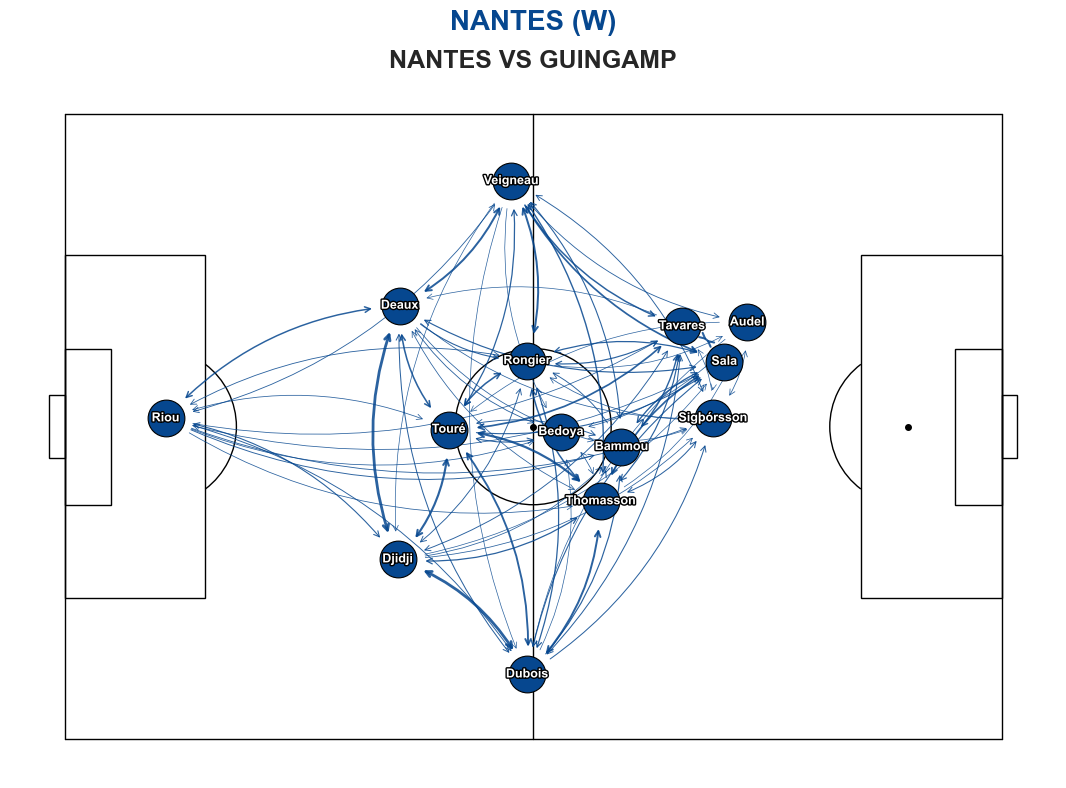

✓ Basic win network 1 saved to: ..\viz\network_basic_win_1.png

Creating win example 2/3...


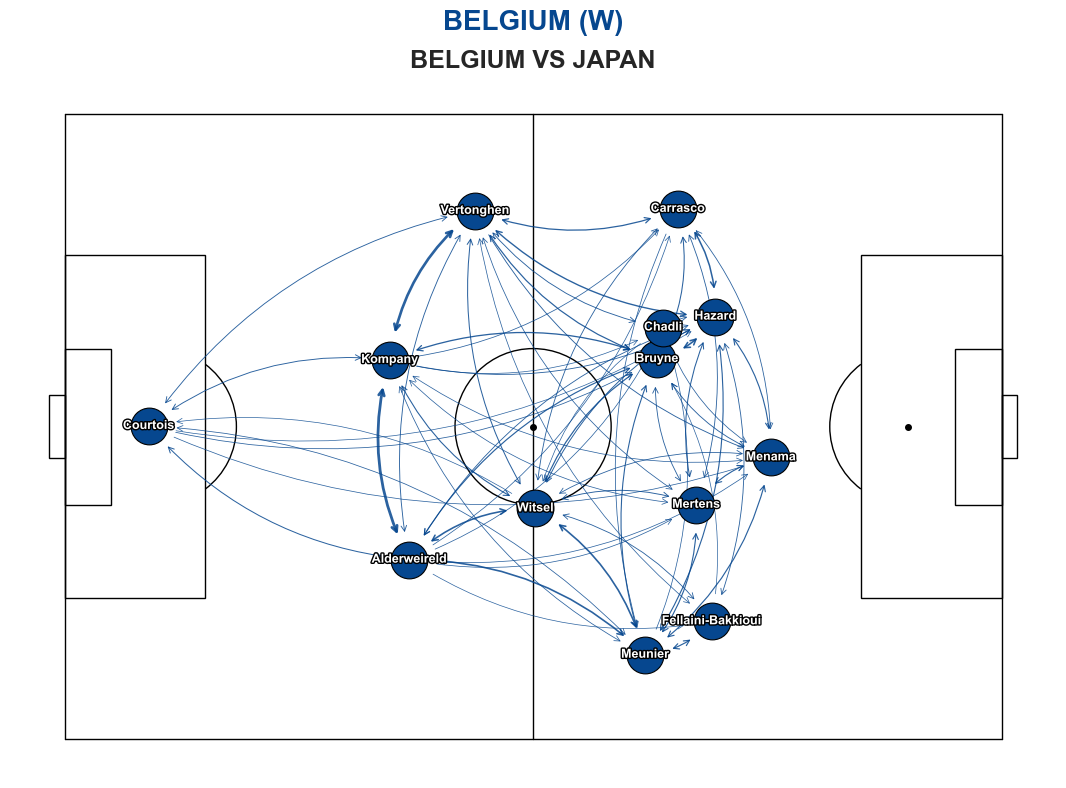

✓ Basic win network 2 saved to: ..\viz\network_basic_win_2.png

Creating win example 3/3...


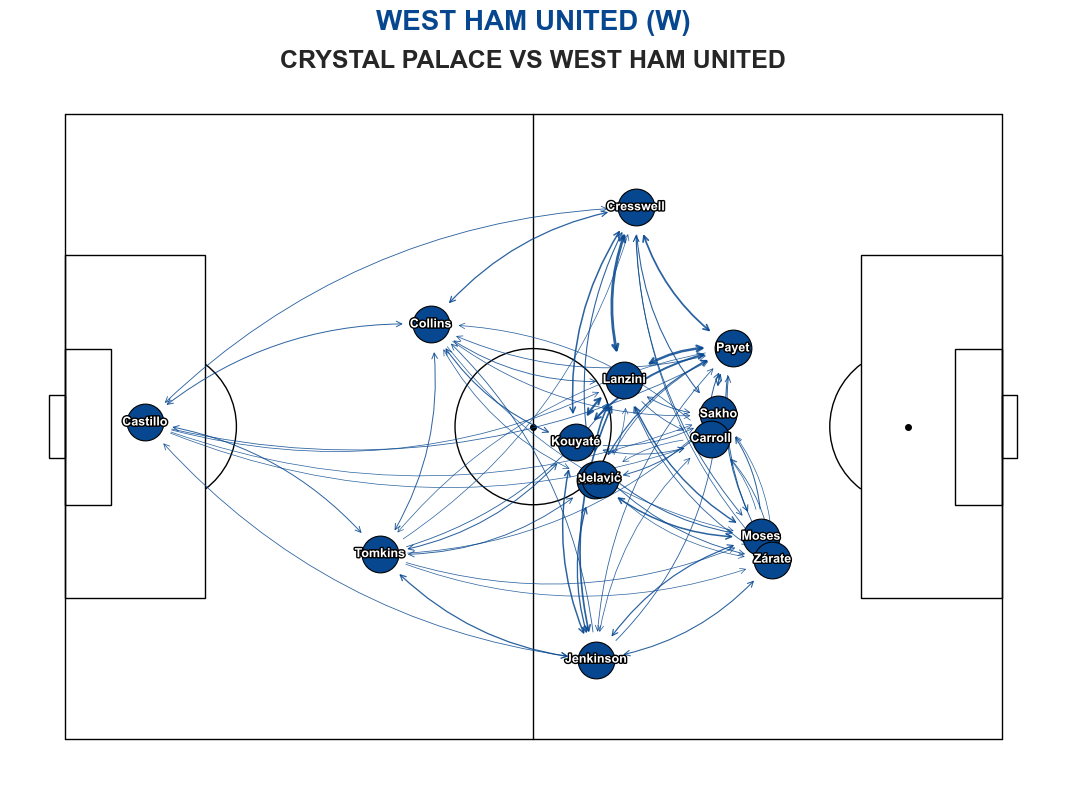

✓ Basic win network 3 saved to: ..\viz\network_basic_win_3.png

Creating loss example 1/3...


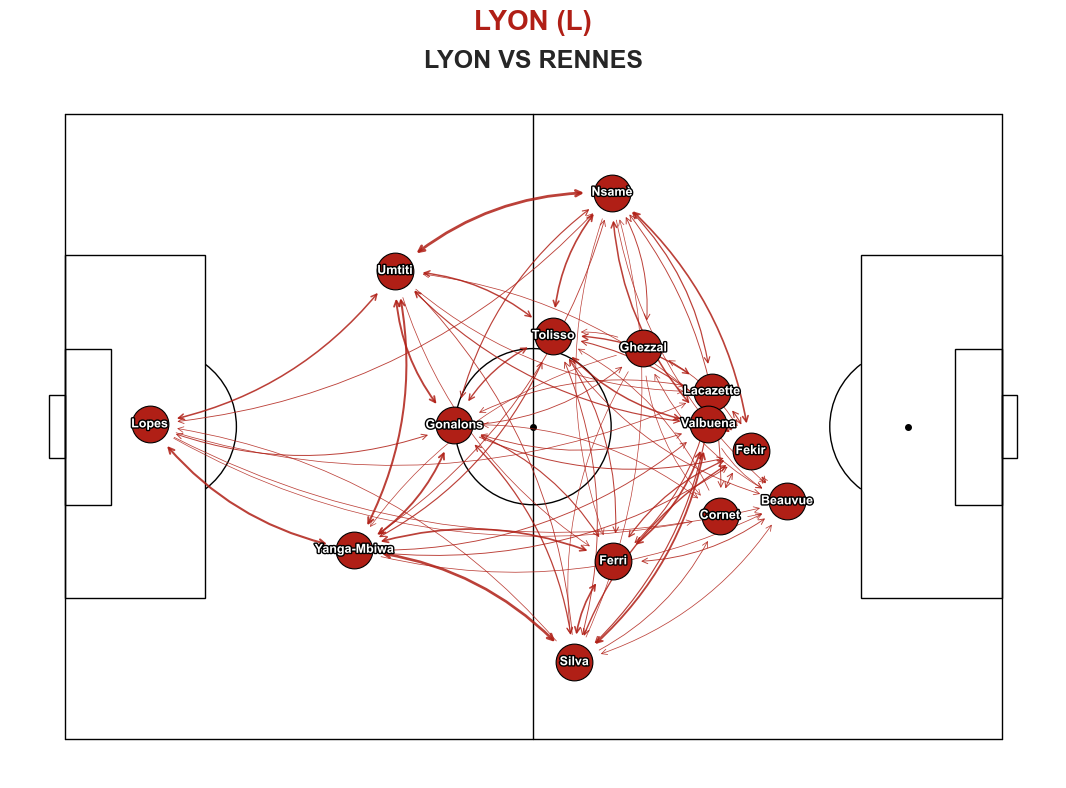

✓ Basic loss network 1 saved to: ..\viz\network_basic_loss_1.png

Creating loss example 2/3...


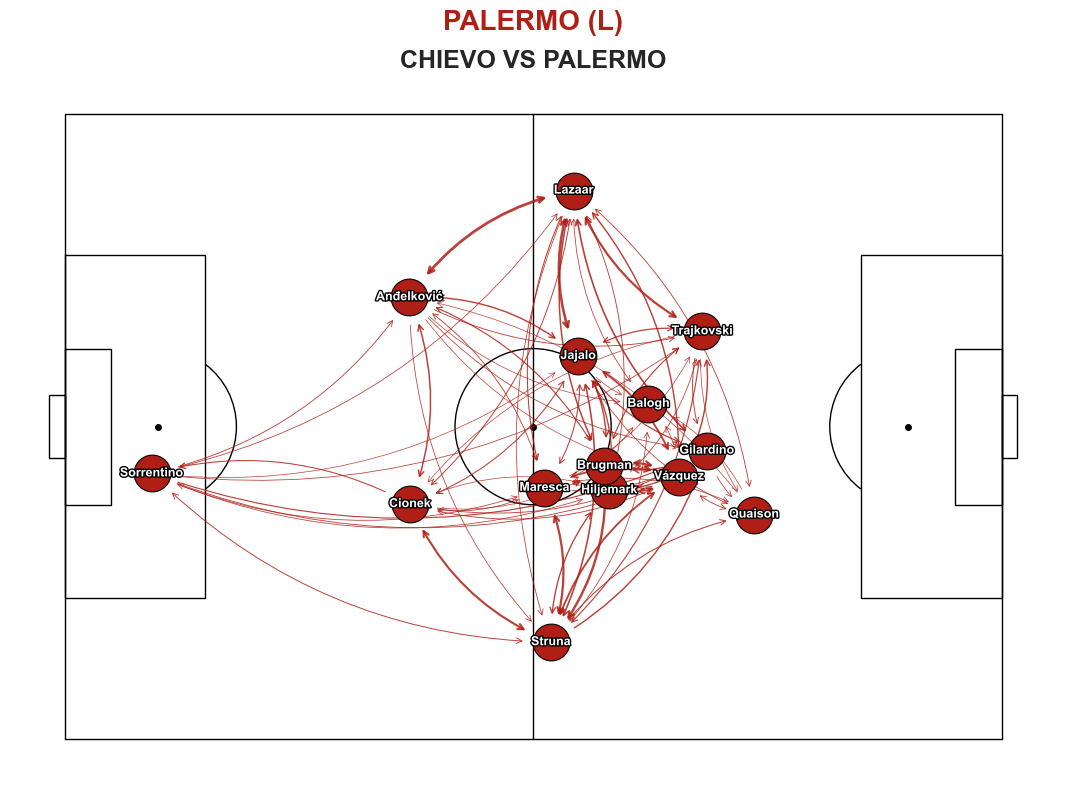

✓ Basic loss network 2 saved to: ..\viz\network_basic_loss_2.png

Creating loss example 3/3...


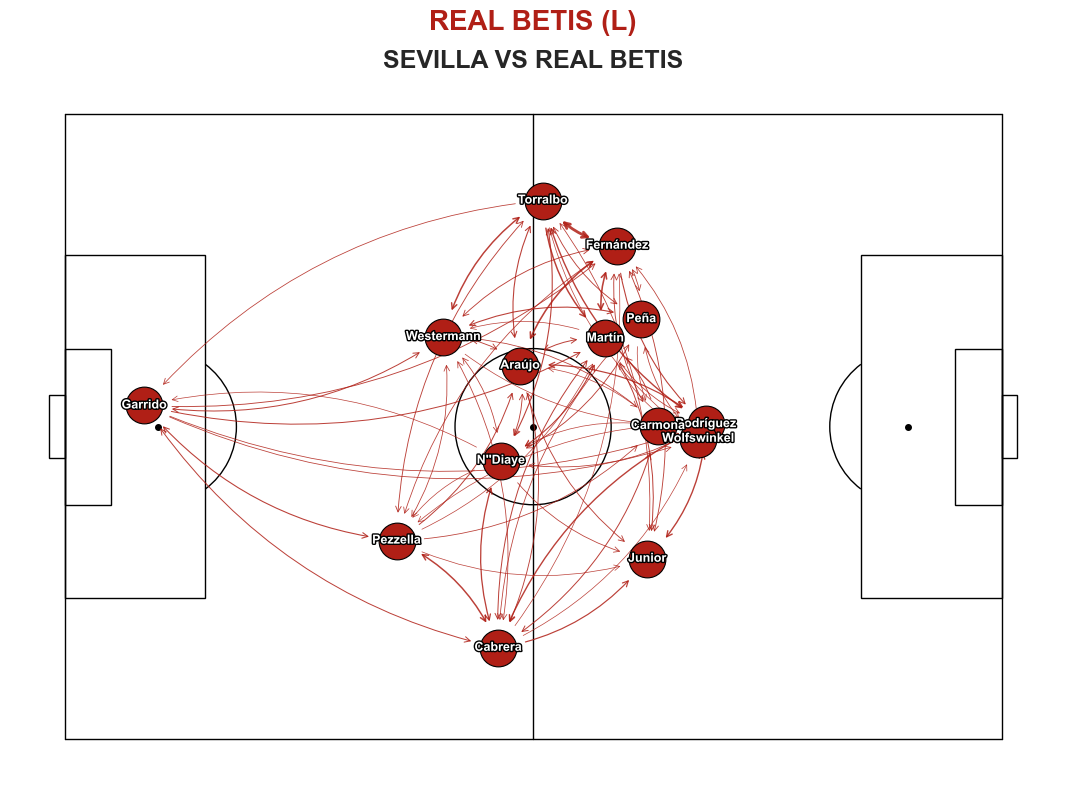

✓ Basic loss network 3 saved to: ..\viz\network_basic_loss_3.png


In [6]:
# Generate basic network examples
print("=== GENERATING BASIC NETWORK EXAMPLES ===")

# Generate 3 random winning team networks
for i in range(3):
    print(f"\nCreating win example {i+1}/3...")
    fig_win, ax_win = visualize_basic_network(
        network_summary, network_edges, player_positions,
        random_selection=True, final_result=1
    )
    
    plt.show()
    
    save_path = VIZ_PATH / f"network_basic_win_{i+1}.png"
    fig_win.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Basic win network {i+1} saved to: {save_path}")
    plt.close(fig_win)

# Generate 3 random losing team networks
for i in range(3):
    print(f"\nCreating loss example {i+1}/3...")
    fig_loss, ax_loss = visualize_basic_network(
        network_summary, network_edges, player_positions,
        random_selection=True, final_result=0
    )
    
    plt.show()
    
    save_path = VIZ_PATH / f"network_basic_loss_{i+1}.png"
    fig_loss.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ Basic loss network {i+1} saved to: {save_path}")
    plt.close(fig_loss)


=== GENERATING DENSITY MAP EXAMPLES ===

Creating density map - win example...


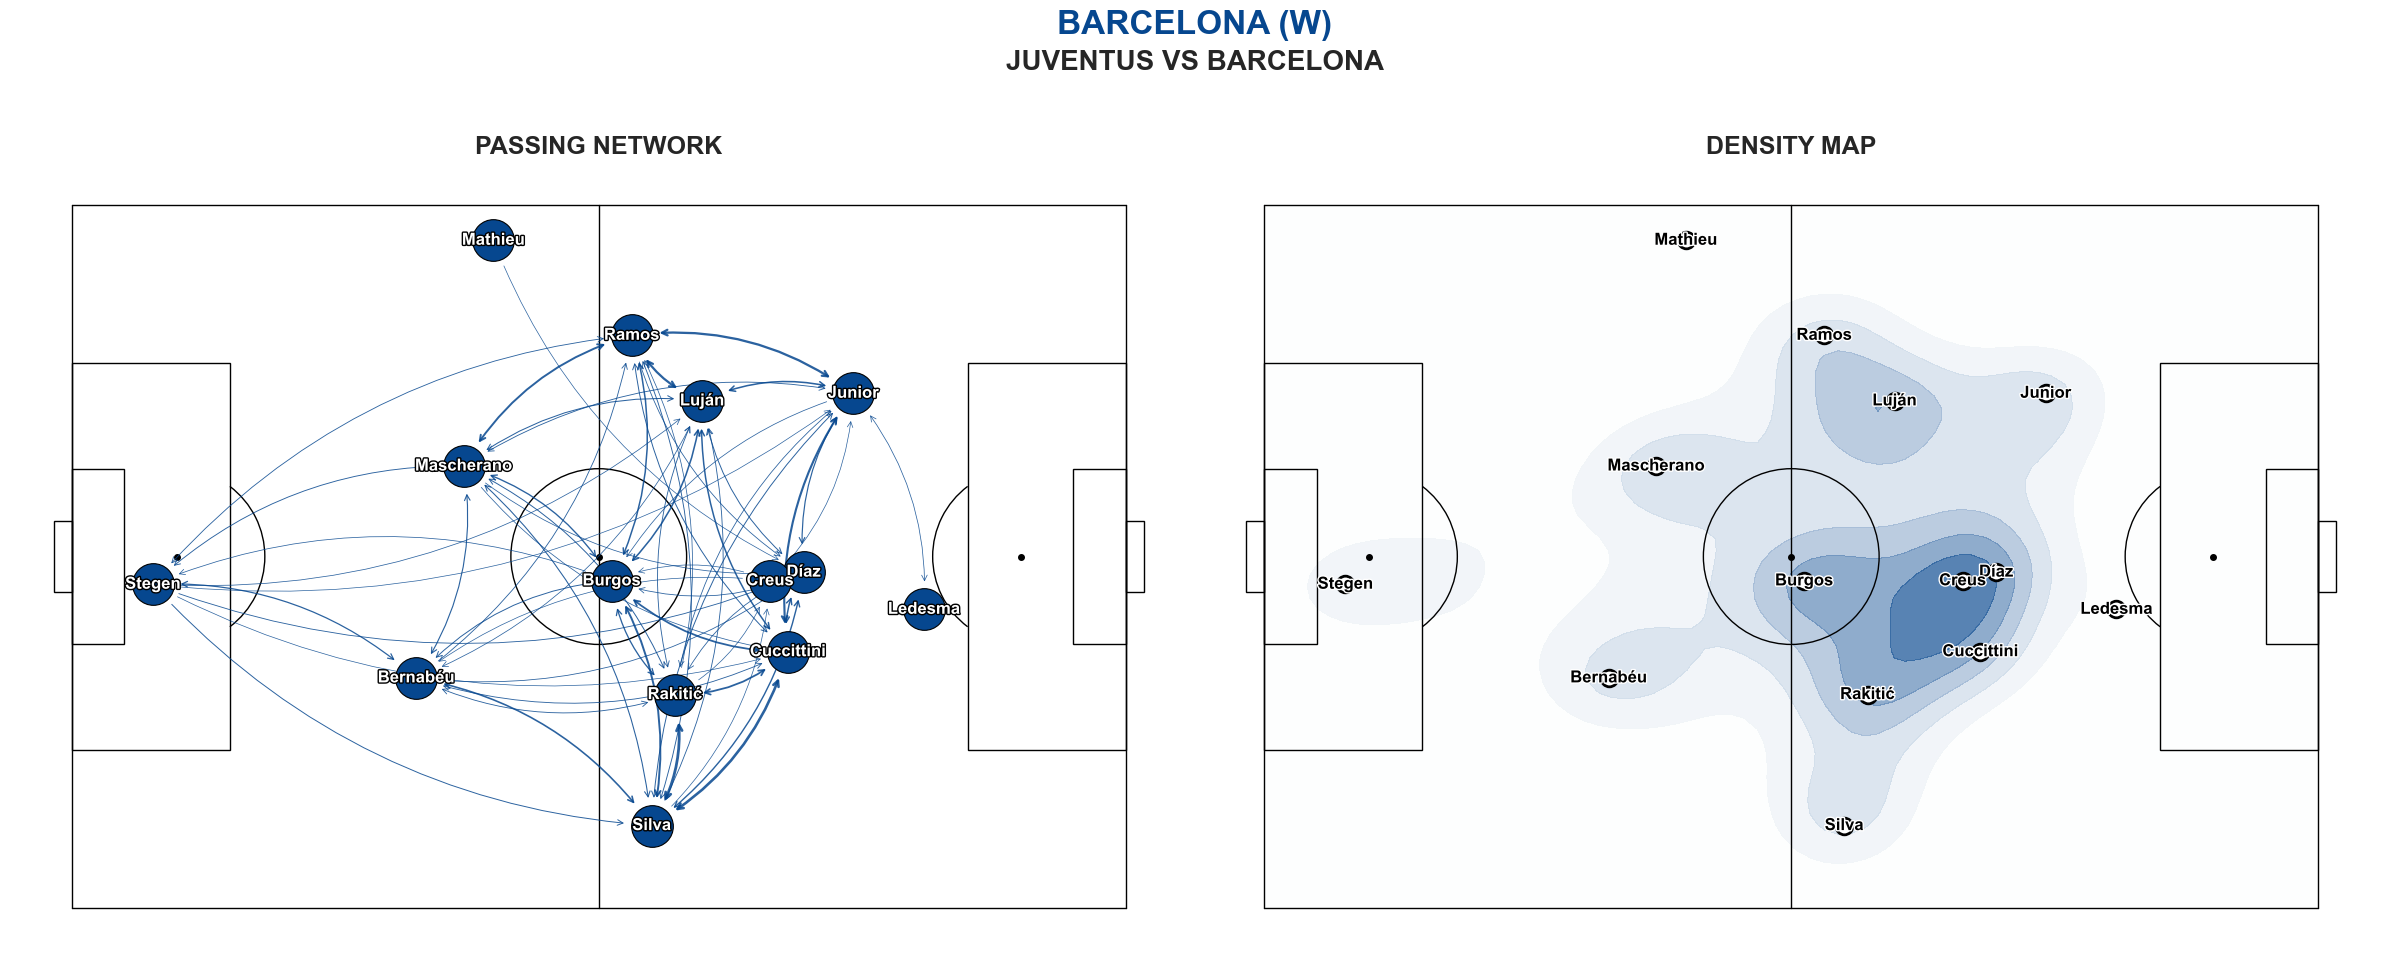

✓ Density win visualization saved to: ..\viz\network_density_win.png

Creating density map - loss example...


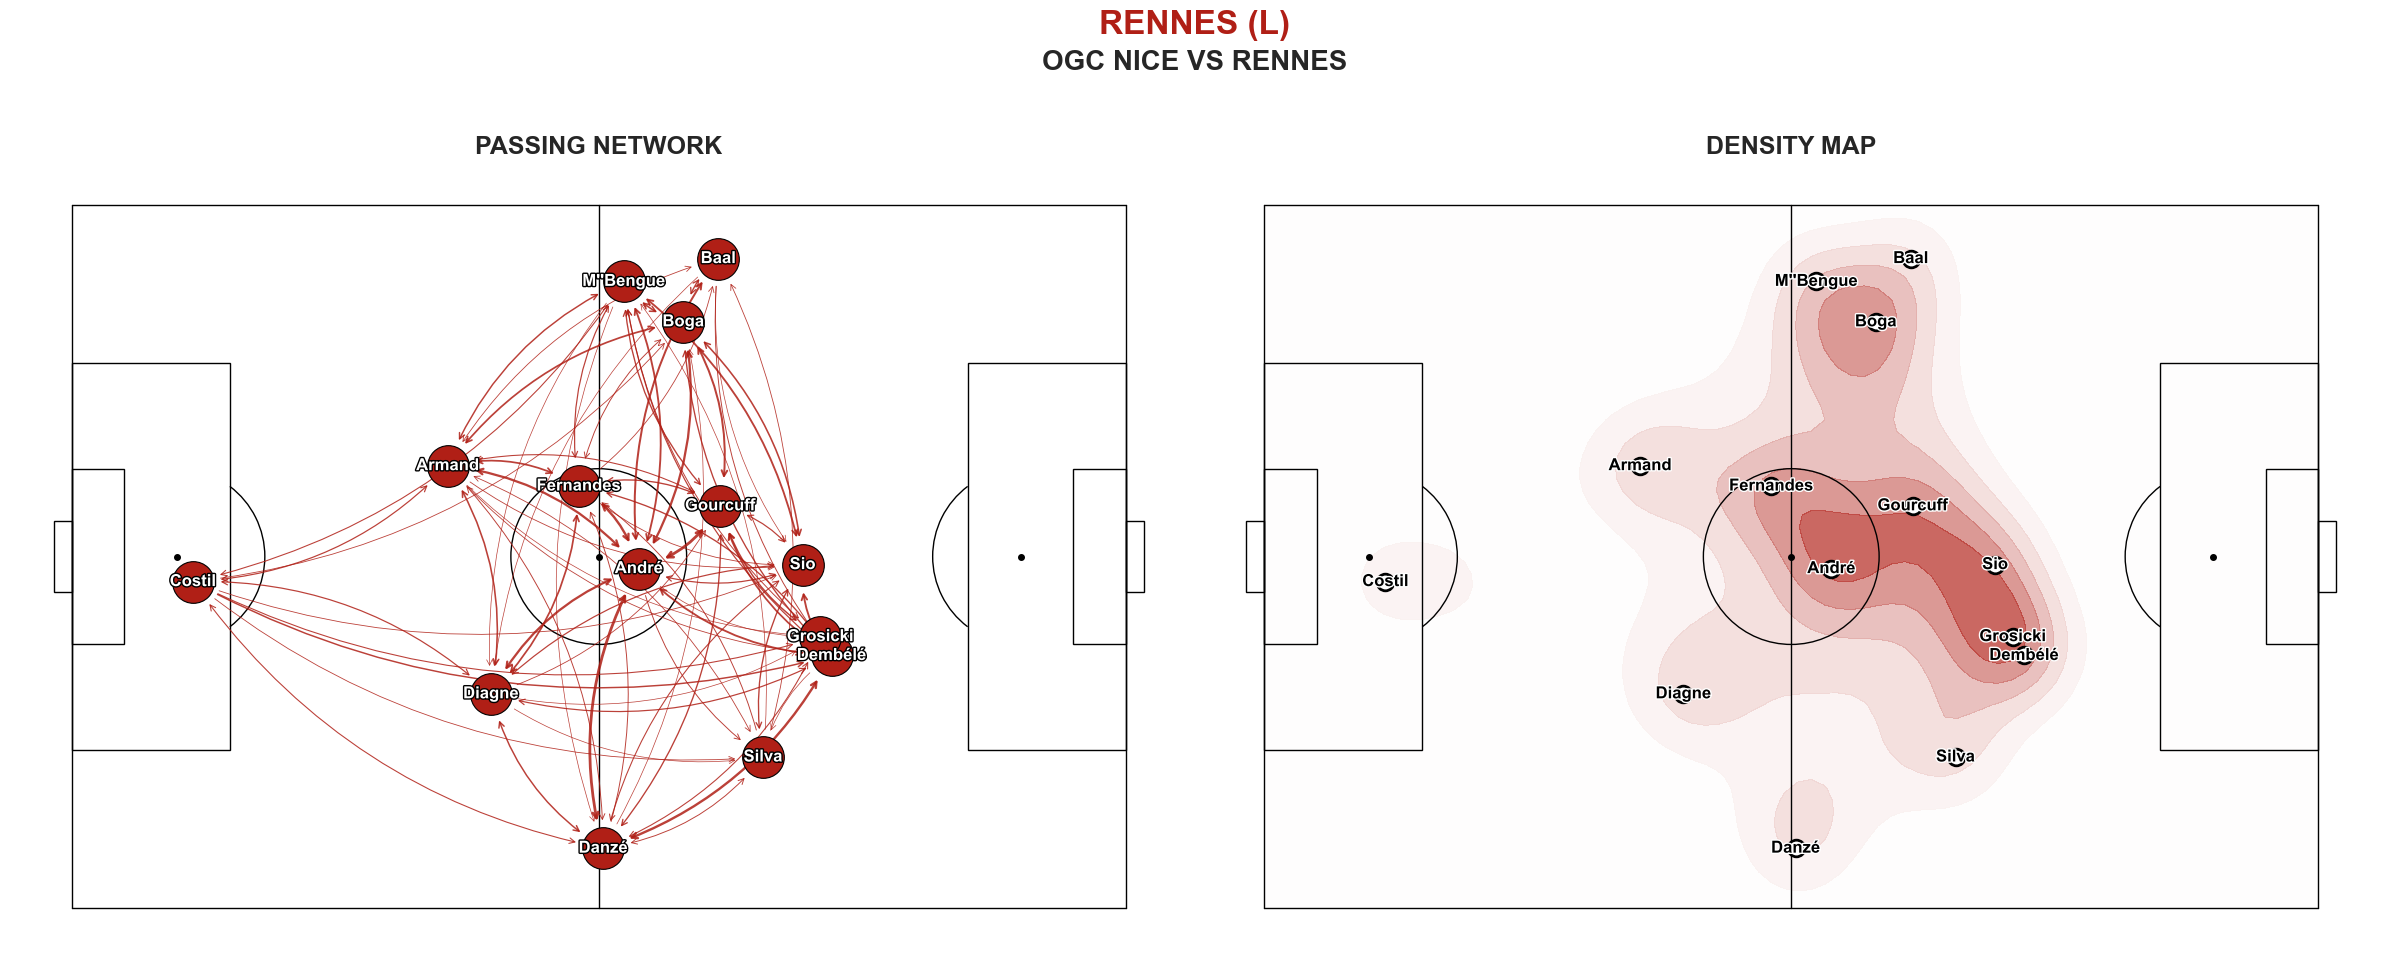

✓ Density loss visualization saved to: ..\viz\network_density_loss.png


In [7]:
# Generate density map examples
print("\n=== GENERATING DENSITY MAP EXAMPLES ===")

# Generate winning team density example
print("\nCreating density map - win example...")
fig_win_density, axes_win = visualize_network_with_density(
    network_summary, network_edges, player_positions,
    random_selection=True, final_result=1
)

plt.show()

save_path = VIZ_PATH / "network_density_win.png"
fig_win_density.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Density win visualization saved to: {save_path}")
plt.close(fig_win_density)

# Generate losing team density example
print("\nCreating density map - loss example...")
fig_loss_density, axes_loss = visualize_network_with_density(
    network_summary, network_edges, player_positions,
    random_selection=True, final_result=0
)

plt.show()

save_path = VIZ_PATH / "network_density_loss.png"
fig_loss_density.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Density loss visualization saved to: {save_path}")
plt.close(fig_loss_density)

## **7. Advanced Centrality Visualization**

In [8]:
def visualize_centrality_analysis(network_summary: pd.DataFrame,
                                 network_edges: pd.DataFrame,
                                 player_positions: pd.DataFrame,
                                 centrality_type: str = 'degree',
                                 match_id: Optional[int] = None,
                                 team: Optional[str] = None,
                                 random_selection: bool = False,
                                 final_result: Optional[int] = None,
                                 save_path: Optional[Path] = None,
                                 top_connections_per_player: int = 2) -> Tuple[plt.Figure, Tuple[plt.Axes, plt.Axes]]:
    """Create network visualization highlighting centrality measures."""
    
    # Selection logic (same as previous functions)
    filtered_networks = network_summary.copy()
    if final_result is not None:
        filtered_networks = filtered_networks[filtered_networks['final_result'] == final_result]
    
    if random_selection:
        selected_row = filtered_networks.sample(n=1).iloc[0]
        match_id = selected_row['match_id']
        team = selected_row['team']
    else:
        if match_id is None:
            selected_row = filtered_networks.iloc[0]
            match_id = selected_row['match_id']
        if team is None:
            match_data = filtered_networks[filtered_networks['match_id'] == match_id]
            selected_row = match_data.iloc[0]
            team = selected_row['team']
    
    network_info = network_summary[
        (network_summary['match_id'] == match_id) & 
        (network_summary['team'] == team)
    ].iloc[0]
    
    result = network_info.get('final_result', 0)
    node_color = '#06478f' if result == 1 else '#b01f16'
    result_suffix = 'W' if result == 1 else 'L'
    
    team_positions = player_positions[
        (player_positions['match_id'] == match_id) & 
        (player_positions['team'] == team)
    ]
    team_edges = network_edges[
        (network_edges['match_id'] == match_id) & 
        (network_edges['team'] == team)
    ]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    draw_statsbomb_pitch(ax1)
    draw_statsbomb_pitch(ax2)
    
    # Build network
    G = nx.DiGraph()
    pos = {}
    node_labels = {}
    
    for _, player in team_positions.iterrows():
        player_id = player['player_id']
        player_name = player['player'].split()[-1]
        G.add_node(player_id)
        pos[player_id] = (player['location_x'], player['location_y'])
        node_labels[player_id] = player_name
    
    # Process bidirectional edges
    bidirectional_edges = {}
    for _, edge in team_edges.iterrows():
        source, target, weight = edge['source_id'], edge['target_id'], edge['weight']
        if source == target:
            continue
        
        edge_key = tuple(sorted([source, target]))
        if edge_key not in bidirectional_edges:
            bidirectional_edges[edge_key] = {
                'weight': weight, 'bidirectional': False,
                'source': source, 'target': target
            }
        else:
            bidirectional_edges[edge_key]['bidirectional'] = True
            bidirectional_edges[edge_key]['weight'] += weight
    
    edge_list = []
    edge_weights = []
    bidirectional_flags = []
    
    for (u, v), info in bidirectional_edges.items():
        weight = info['weight']
        if info['bidirectional']:
            G.add_edge(u, v, weight=weight)
            edge_list.append((u, v))
            bidirectional_flags.append(True)
        else:
            G.add_edge(info['source'], info['target'], weight=weight)
            edge_list.append((info['source'], info['target']))
            bidirectional_flags.append(False)
        edge_weights.append(weight)
    
    # Draw basic network in first subplot
    if edge_weights:
        min_weight, max_weight = min(edge_weights), max(edge_weights)
        edge_widths = [
            0.5 + 1.5 * (w - min_weight) / (max_weight - min_weight + 1e-6)
            for w in edge_weights
        ]
    else:
        edge_widths = [0.5] * len(edge_list)
    
    for (u, v), width, is_bidirectional in zip(edge_list, edge_widths, bidirectional_flags):
        if u not in pos or v not in pos:
            continue
        arrow_style = '<->' if is_bidirectional else '->'
        ax1.annotate(
            '', xy=pos[v], xytext=pos[u],
            arrowprops=dict(
                arrowstyle=arrow_style, color=node_color, alpha=0.85, lw=width,
                connectionstyle='arc3,rad=0.2', shrinkA=20, shrinkB=20
            )
        )
    
    # Draw nodes in first subplot
    nodes1 = nx.draw_networkx_nodes(
        G, pos, ax=ax1, node_size=900, node_color=node_color,
        edgecolors='black', linewidths=0.8
    )
    nodes1.set_zorder(10)
    
    for player_id, (x, y) in pos.items():
        text = ax1.text(
            x, y, node_labels[player_id], fontsize=12, fontweight='bold',
            ha='center', va='center', color='white', zorder=20
        )
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='black'),
            path_effects.Normal()
        ])
    
    ax1.set_title("PASSING NETWORK", fontsize=18, fontweight='bold')
    
    # === SECOND SUBPLOT: KEY PLAYERS AND MAIN CONNECTIONS ===
    # Calculate centrality of players (total degree)
    from collections import defaultdict
    player_connections = defaultdict(list)
    player_degree = defaultdict(int)
    
    # Count connections for each player
    for (u, v), weight in zip(edge_list, edge_weights):
        if u in pos and v in pos:
            player_connections[u].append((v, weight))
            player_connections[v].append((u, weight))
            player_degree[u] += weight
            player_degree[v] += weight
    
    # Identify players with most connections
    key_players = set()
    if player_degree:
        max_degree = max(player_degree.values())
        min_degree = min(player_degree.values())
        
        # Identify key players (top 30% of connections)
        for pid in pos.keys():
            degree = player_degree.get(pid, 0)
            normalized_degree = (degree - min_degree) / (max_degree - min_degree + 1e-6)
            if normalized_degree > 0.7:  # Top 30%
                key_players.add(pid)
    
    # Select only the strongest edges for each player
    top_edges = []
    top_edge_weights = []
    
    for player_id, connections in player_connections.items():
        # Sort connections by weight and take top N
        connections.sort(key=lambda x: x[1], reverse=True)
        top_connections = connections[:top_connections_per_player]
        
        for target_id, weight in top_connections:
            # Check if edge already added in opposite direction
            edge_exists = False
            for existing_edge in top_edges:
                if (existing_edge[0] == target_id and existing_edge[1] == player_id):
                    edge_exists = True
                    break
            
            if not edge_exists:
                top_edges.append((player_id, target_id))
                top_edge_weights.append(weight)
    
    # Draw only main edges
    if top_edge_weights:
        mn, mx = min(top_edge_weights), max(top_edge_weights)
        edge_widths = [1.0 + 3.0 * (w - mn) / (mx - mn + 1e-6) for w in top_edge_weights]
    else:
        edge_widths = [1.0] * len(top_edges)
    
    for (u, v), lw in zip(top_edges, edge_widths):
        if u not in pos or v not in pos:
            continue
        
        # Draw line without arrows
        ax2.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]], 
                color=node_color, alpha=0.9, linewidth=lw, zorder=5)
    
    # Draw nodes with differentiated borders
    # First draw all normal nodes
    regular_players = [pid for pid in pos.keys() if pid not in key_players]
    key_player_list = [pid for pid in pos.keys() if pid in key_players]
    
    # Draw regular players with black border
    if regular_players:
        regular_nodes = nx.draw_networkx_nodes(
            G, pos, nodelist=regular_players, ax=ax2, node_size=900,
            node_color=node_color, edgecolors='black', linewidths=0.8
        )
        regular_nodes.set_zorder(10)
    
    # Draw key players with gold border
    if key_player_list:
        key_nodes = nx.draw_networkx_nodes(
            G, pos, nodelist=key_player_list, ax=ax2, node_size=900,
            node_color=node_color, edgecolors='gold', linewidths=3
        )
        key_nodes.set_zorder(10)
    
    # Add labels
    for nid, (x, y) in pos.items():
        txt = ax2.text(x, y, node_labels[nid],
                      fontsize=12, fontweight='bold',
                      ha='center', va='center', color='white', zorder=20)
        txt.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='black'),
            path_effects.Normal()
        ])
    
    ax2.set_title("KEY PLAYERS & MAIN CONNECTIONS", fontsize=18, fontweight='bold')
    
    # Set main titles
    main_title = f"{team.upper()} ({result_suffix})"
    subtitle = f"{network_info['home_abbrev_name']} vs {network_info['away_abbrev_name']}"
    plt.suptitle(main_title, fontsize=24, fontweight='bold', color=node_color)
    fig.text(0.5, 0.92, subtitle.upper(), fontsize=20, fontweight='bold', ha='center')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Figure saved to: {save_path}")
    
    return fig, (ax1, ax2)


=== GENERATING CENTRALITY ANALYSIS EXAMPLES ===

Creating degree centrality - win example...


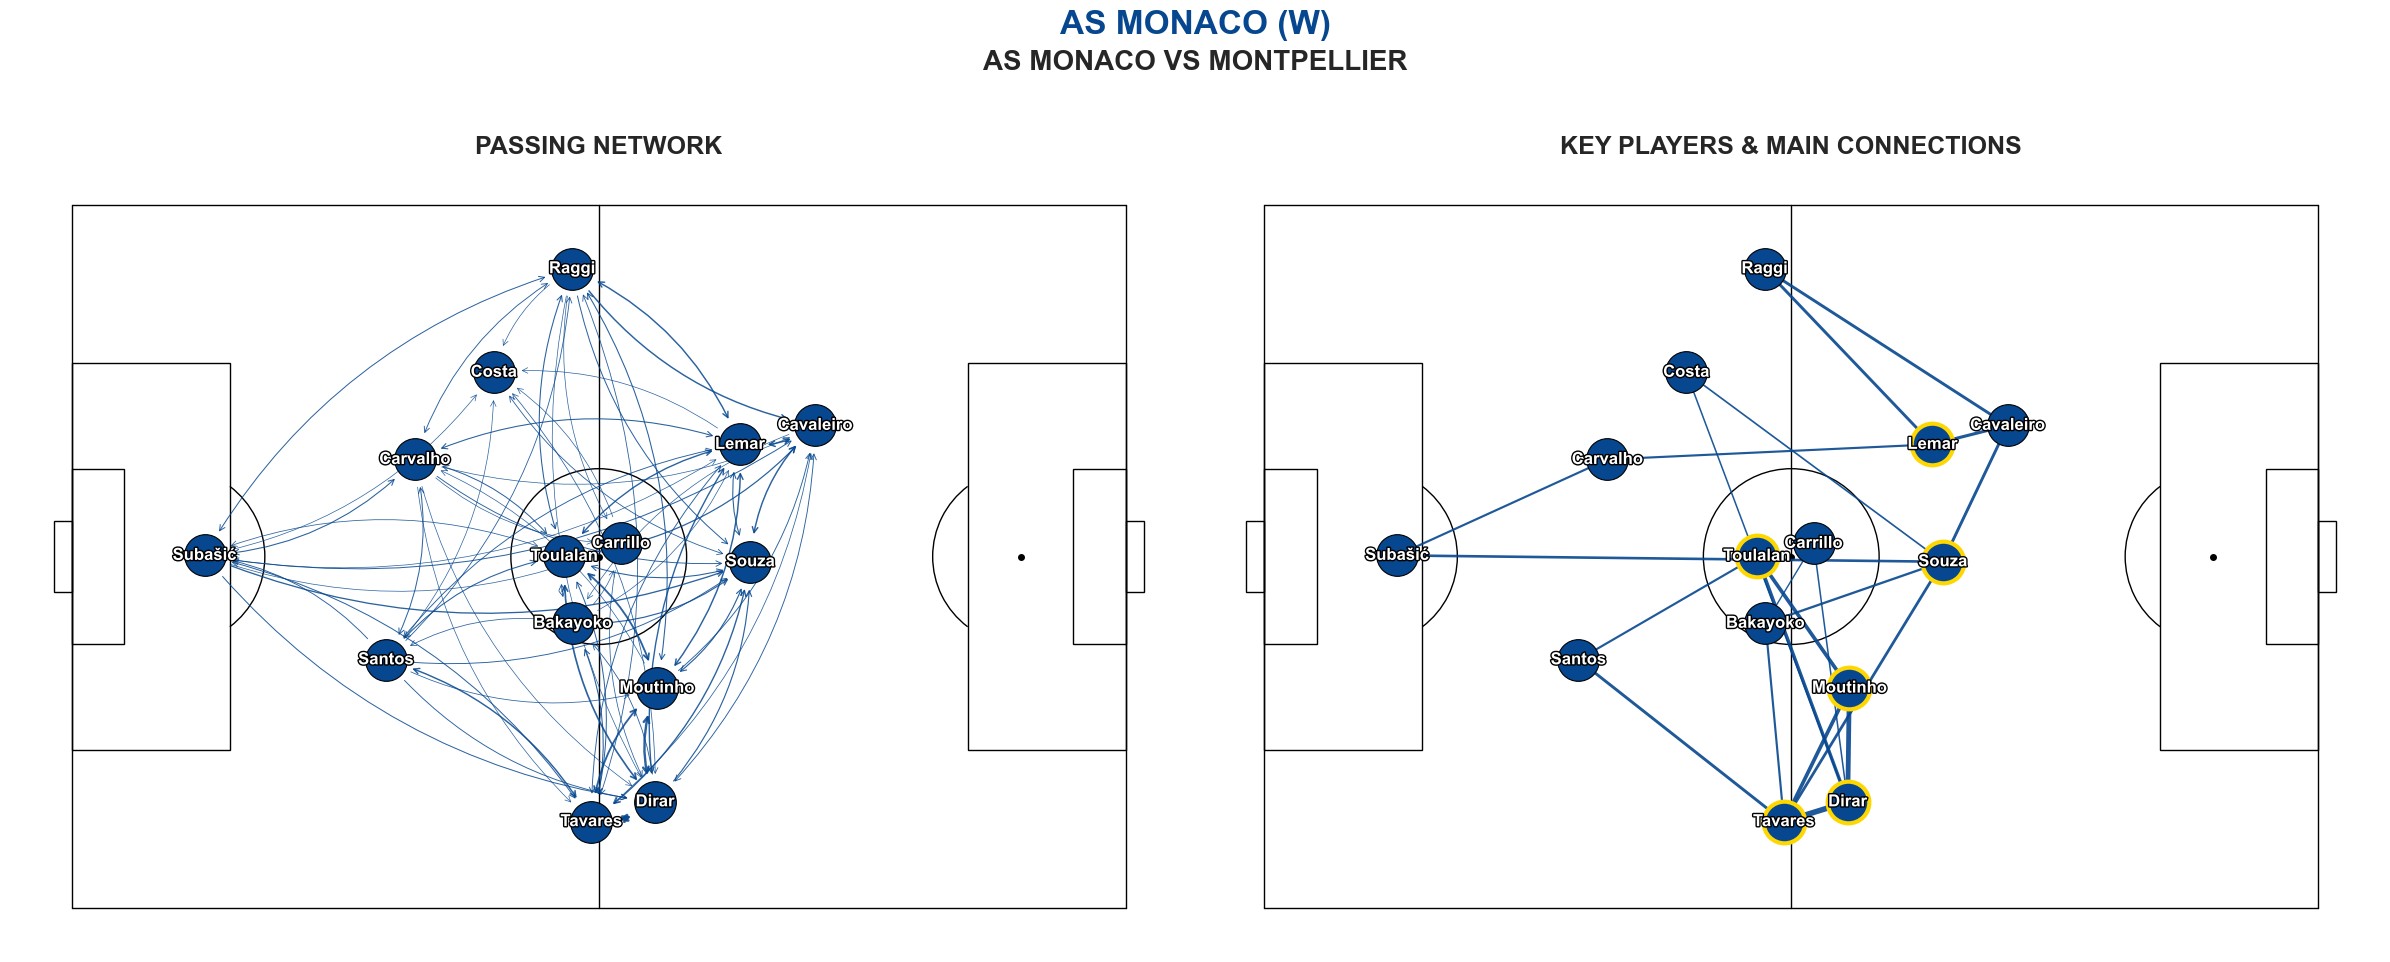

✓ Degree win visualization saved to: ..\viz\network_degree_win.png

Creating degree centrality - loss example...


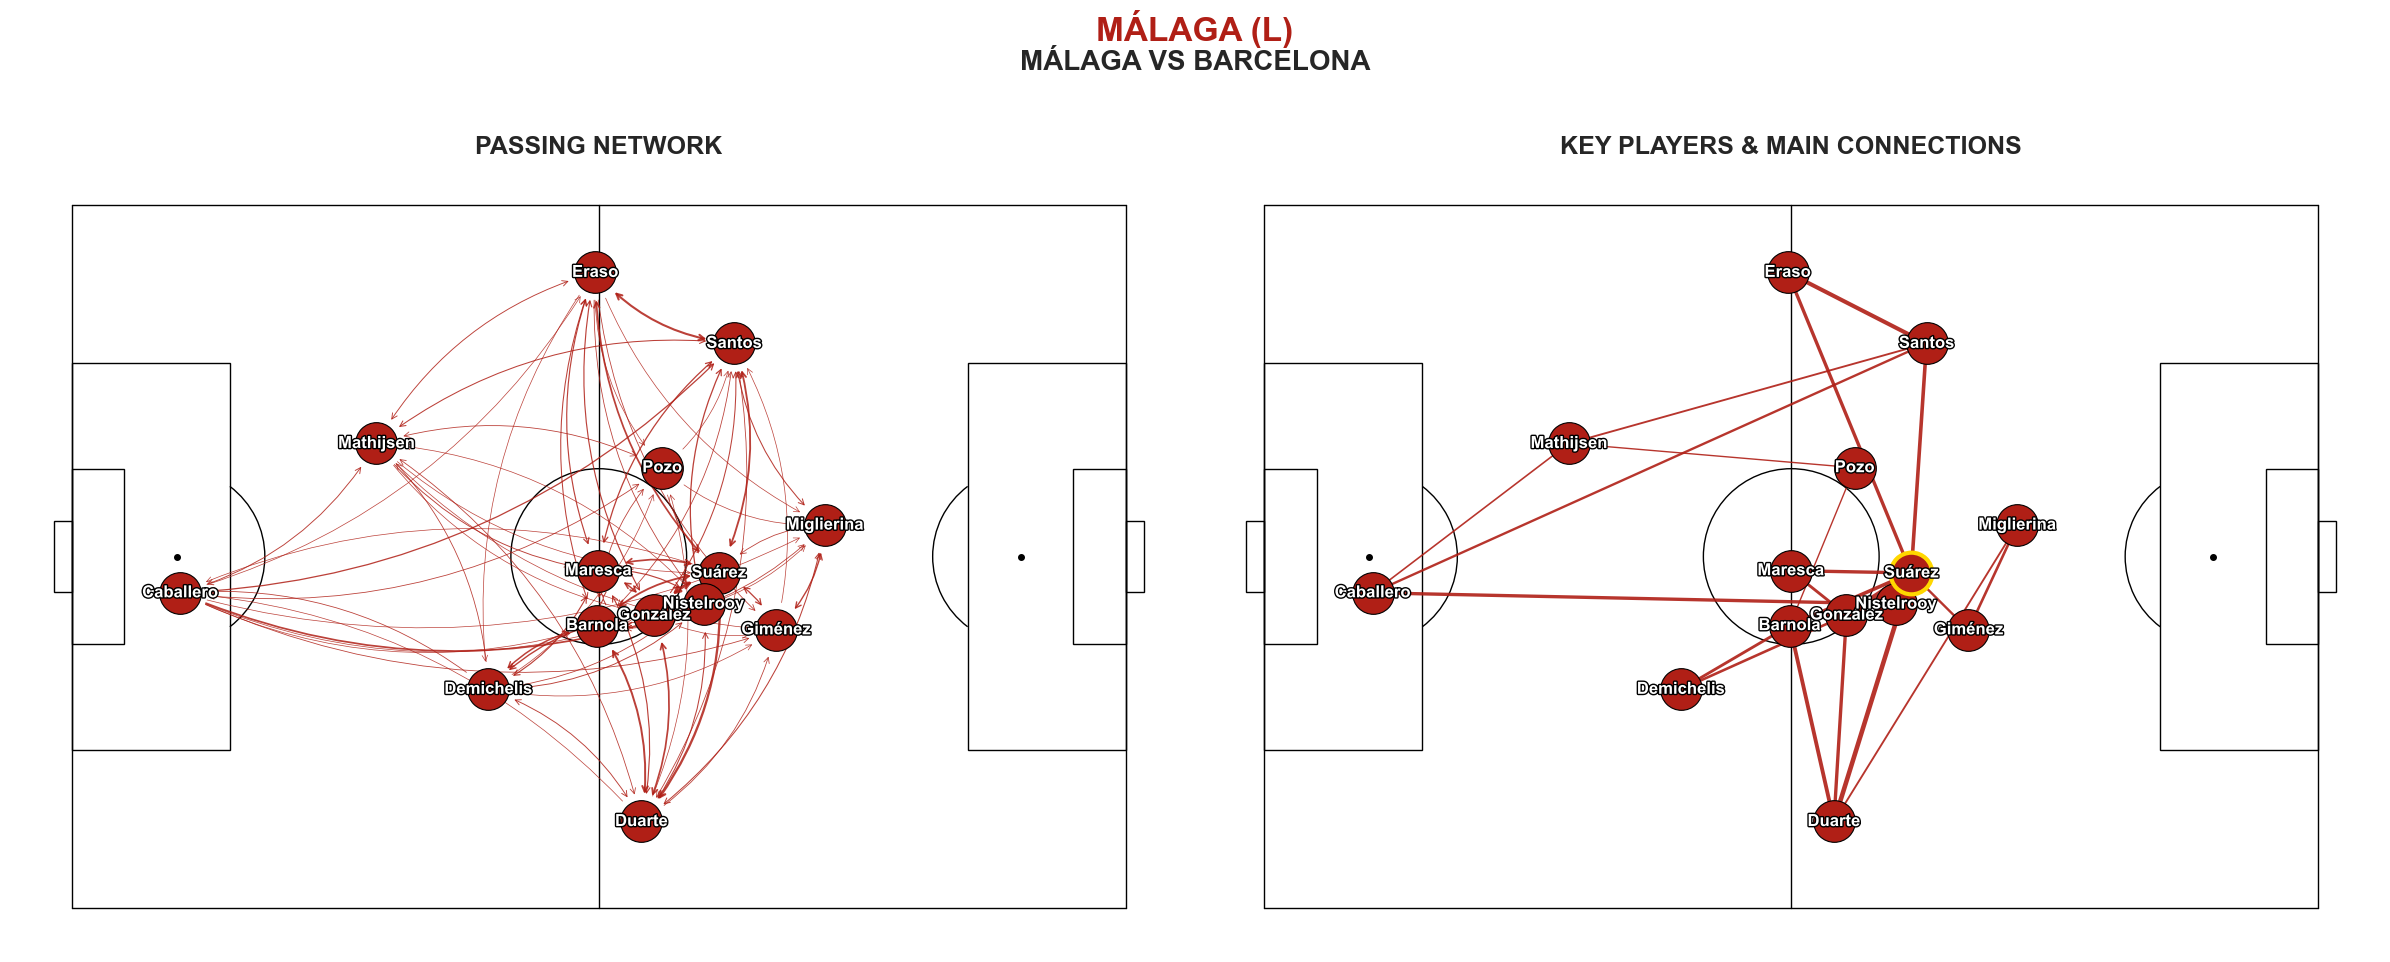

✓ Degree loss visualization saved to: ..\viz\network_degree_loss.png


In [9]:
# Generate centrality analysis examples
print("\n=== GENERATING CENTRALITY ANALYSIS EXAMPLES ===")

print("\nCreating degree centrality - win example...")
fig_win, axes_win = visualize_centrality_analysis(
    network_summary, network_edges, player_positions,
    centrality_type='degree', random_selection=True, final_result=1
)

plt.show()

save_path = VIZ_PATH / "network_degree_win.png"
fig_win.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Degree win visualization saved to: {save_path}")
plt.close(fig_win)

print("\nCreating degree centrality - loss example...")
fig_loss, axes_loss = visualize_centrality_analysis(
    network_summary, network_edges, player_positions,
    centrality_type='degree', random_selection=True, final_result=0
)

plt.show()

save_path = VIZ_PATH / "network_degree_loss.png"
fig_loss.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Degree loss visualization saved to: {save_path}")
plt.close(fig_loss)

## **8. Betweenness Centrality Visualization**

In [10]:
def visualize_betweenness_analysis(network_summary: pd.DataFrame,
                                  network_edges: pd.DataFrame,
                                  player_positions: pd.DataFrame,
                                  match_id: Optional[int] = None,
                                  team: Optional[str] = None,
                                  random_selection: bool = False,
                                  final_result: Optional[int] = None,
                                  save_path: Optional[Path] = None,
                                  top_connections_per_player: int = 2) -> Tuple[plt.Figure, Tuple[plt.Axes, plt.Axes]]:
    """Create network visualization highlighting betweenness centrality (playmakers)."""
    
    # Selection logic
    filtered_networks = network_summary.copy()
    if final_result is not None:
        filtered_networks = filtered_networks[filtered_networks['final_result'] == final_result]
    
    if random_selection:
        selected_row = filtered_networks.sample(n=1).iloc[0]
        match_id = selected_row['match_id']
        team = selected_row['team']
    else:
        if match_id is None:
            selected_row = filtered_networks.iloc[0]
            match_id = selected_row['match_id']
        if team is None:
            match_data = filtered_networks[filtered_networks['match_id'] == match_id]
            selected_row = match_data.iloc[0]
            team = selected_row['team']
    
    network_info = network_summary[
        (network_summary['match_id'] == match_id) & 
        (network_summary['team'] == team)
    ].iloc[0]
    
    result = network_info.get('final_result', 0)
    node_color = '#06478f' if result == 1 else '#b01f16'
    result_suffix = 'W' if result == 1 else 'L'
    
    team_positions = player_positions[
        (player_positions['match_id'] == match_id) & 
        (player_positions['team'] == team)
    ]
    team_edges = network_edges[
        (network_edges['match_id'] == match_id) & 
        (network_edges['team'] == team)
    ]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
    draw_statsbomb_pitch(ax1)
    draw_statsbomb_pitch(ax2)
    
    # Build network
    G = nx.DiGraph()
    pos = {}
    node_labels = {}
    
    for _, player in team_positions.iterrows():
        player_id = player['player_id']
        player_name = player['player'].split()[-1]
        G.add_node(player_id)
        pos[player_id] = (player['location_x'], player['location_y'])
        node_labels[player_id] = player_name
    
    # Process bidirectional edges
    bidirectional_edges = {}
    for _, edge in team_edges.iterrows():
        source, target, weight = edge['source_id'], edge['target_id'], edge['weight']
        if source == target:
            continue
        
        edge_key = tuple(sorted([source, target]))
        if edge_key not in bidirectional_edges:
            bidirectional_edges[edge_key] = {
                'weight': weight, 'bidirectional': False,
                'source': source, 'target': target
            }
        else:
            bidirectional_edges[edge_key]['bidirectional'] = True
            bidirectional_edges[edge_key]['weight'] += weight
    
    edge_list = []
    edge_weights = []
    bidirectional_flags = []
    
    for (u, v), info in bidirectional_edges.items():
        weight = info['weight']
        if info['bidirectional']:
            G.add_edge(u, v, weight=weight)
            edge_list.append((u, v))
            bidirectional_flags.append(True)
        else:
            G.add_edge(info['source'], info['target'], weight=weight)
            edge_list.append((info['source'], info['target']))
            bidirectional_flags.append(False)
        edge_weights.append(weight)
    
    # Draw basic network in first subplot
    if edge_weights:
        min_weight, max_weight = min(edge_weights), max(edge_weights)
        edge_widths = [
            0.5 + 1.5 * (w - min_weight) / (max_weight - min_weight + 1e-6)
            for w in edge_weights
        ]
    else:
        edge_widths = [0.5] * len(edge_list)
    
    for (u, v), width, is_bidirectional in zip(edge_list, edge_widths, bidirectional_flags):
        if u not in pos or v not in pos:
            continue
        arrow_style = '<->' if is_bidirectional else '->'
        ax1.annotate(
            '', xy=pos[v], xytext=pos[u],
            arrowprops=dict(
                arrowstyle=arrow_style, color=node_color, alpha=0.85, lw=width,
                connectionstyle='arc3,rad=0.2', shrinkA=20, shrinkB=20
            )
        )
    
    # Draw nodes in first subplot
    nodes1 = nx.draw_networkx_nodes(
        G, pos, ax=ax1, node_size=900, node_color=node_color,
        edgecolors='black', linewidths=0.8
    )
    nodes1.set_zorder(10)
    
    for player_id, (x, y) in pos.items():
        text = ax1.text(
            x, y, node_labels[player_id], fontsize=12, fontweight='bold',
            ha='center', va='center', color='white', zorder=20
        )
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='black'),
            path_effects.Normal()
        ])
    
    ax1.set_title("PASSING NETWORK", fontsize=18, fontweight='bold')
    
    # === SECOND SUBPLOT: BETWEENNESS CENTRALITY ===
    # Create undirected graph for betweenness calculation
    G_undirected = nx.Graph()
    for (u, v), weight in zip(edge_list, edge_weights):
        if u in pos and v in pos:
            if G_undirected.has_edge(u, v):
                G_undirected[u][v]['weight'] += weight
            else:
                G_undirected.add_edge(u, v, weight=weight)
    
    # Calculate betweenness centrality
    try:
        betweenness = nx.betweenness_centrality(G_undirected, weight='weight', normalized=True)
    except:
        betweenness = {node: 0 for node in G_undirected.nodes()}
    
    # Identify playmakers (high betweenness)
    organizers = set()
    if betweenness:
        max_betweenness = max(betweenness.values()) if betweenness.values() else 0
        min_betweenness = min(betweenness.values()) if betweenness.values() else 0
        
        # Identify playmakers (top 30% in betweenness)
        for pid in pos.keys():
            centrality = betweenness.get(pid, 0)
            if max_betweenness > min_betweenness:
                normalized_centrality = (centrality - min_betweenness) / (max_betweenness - min_betweenness)
                if normalized_centrality > 0.7:  # Top 30%
                    organizers.add(pid)
            elif centrality > 0:
                organizers.add(pid)
    
    # Calculate important connections for each player
    from collections import defaultdict
    player_connections = defaultdict(list)
    for (u, v), weight in zip(edge_list, edge_weights):
        if u in pos and v in pos:
            player_connections[u].append((v, weight))
            player_connections[v].append((u, weight))
    
    # Select edges that pass through playmakers or connect different zones
    important_edges = []
    important_edge_weights = []
    
    # Define field zones
    def get_zone(x, y):
        if x < 40:
            return 'defense'
        elif x < 80:
            return 'midfield'
        else:
            return 'attack'
    
    # Prioritize connections that:
    # 1. Involve playmakers (high betweenness)
    # 2. Connect different field zones
    for player_id, connections in player_connections.items():
        connections.sort(key=lambda x: x[1], reverse=True)
        
        # Show more connections for playmakers
        max_connections = top_connections_per_player + 1 if player_id in organizers else top_connections_per_player
        top_connections = connections[:max_connections]
        
        for target_id, weight in top_connections:
            # Check if edge already exists
            edge_exists = False
            for existing_edge in important_edges:
                if (existing_edge[0] == target_id and existing_edge[1] == player_id):
                    edge_exists = True
                    break
            
            if not edge_exists:
                # Bonus for inter-zone connections
                player_zone = get_zone(*pos[player_id])
                target_zone = get_zone(*pos[target_id])
                
                # Add if connects different zones or involves playmaker
                if (player_zone != target_zone or 
                    player_id in organizers or 
                    target_id in organizers):
                    important_edges.append((player_id, target_id))
                    important_edge_weights.append(weight)
    
    # Draw important connections
    if important_edge_weights:
        mn, mx = min(important_edge_weights), max(important_edge_weights)
        edge_widths = [1.0 + 3.0 * (w - mn) / (mx - mn + 1e-6) for w in important_edge_weights]
    else:
        edge_widths = [1.0] * len(important_edges)
    
    for (u, v), lw in zip(important_edges, edge_widths):
        if u not in pos or v not in pos:
            continue
        
        # Highlight inter-zone connections
        player_zone = get_zone(*pos[u])
        target_zone = get_zone(*pos[v])
        
        if player_zone != target_zone:
            # Inter-zone connections with full opacity
            color = node_color
            alpha = 1.0
        else:
            # Intra-zone connections
            color = node_color
            alpha = 0.6
        
        ax2.plot([pos[u][0], pos[v][0]], [pos[u][1], pos[v][1]], 
                color=color, alpha=alpha, linewidth=lw, zorder=5)
    
    # Draw nodes with differentiated borders
    # First draw all normal nodes
    regular_players = [pid for pid in pos.keys() if pid not in organizers]
    organizer_list = [pid for pid in pos.keys() if pid in organizers]
    
    # Draw regular players with black border
    if regular_players:
        regular_nodes = nx.draw_networkx_nodes(
            G, pos, nodelist=regular_players, ax=ax2, node_size=900,
            node_color=node_color, edgecolors='black', linewidths=0.8
        )
        regular_nodes.set_zorder(10)
    
    # Draw playmakers with orange border
    if organizer_list:
        organizer_nodes = nx.draw_networkx_nodes(
            G, pos, nodelist=organizer_list, ax=ax2, node_size=900,
            node_color=node_color, edgecolors='orange', linewidths=3
        )
        organizer_nodes.set_zorder(10)
    
    # Add labels
    for nid, (x, y) in pos.items():
        # Highlight playmaker names
        if nid in organizers:
            fontweight = 'extra bold'
            fontsize = 13
        else:
            fontweight = 'bold'
            fontsize = 12
            
        txt = ax2.text(x, y, node_labels[nid],
                      fontsize=fontsize, fontweight=fontweight,
                      ha='center', va='center', color='white', zorder=20)
        txt.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='black'),
            path_effects.Normal()
        ])
    
    ax2.set_title("PLAYMAKERS & ZONE CONNECTIONS", fontsize=18, fontweight='bold')
    
    # Set main titles
    main_title = f"{team.upper()} ({result_suffix})"
    subtitle = f"{network_info['home_abbrev_name']} vs {network_info['away_abbrev_name']}"
    plt.suptitle(main_title, fontsize=24, fontweight='bold', color=node_color)
    fig.text(0.5, 0.92, subtitle.upper(), fontsize=20, fontweight='bold', ha='center')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Figure saved to: {save_path}")
    
    return fig, (ax1, ax2)


=== GENERATING BETWEENNESS ANALYSIS EXAMPLES ===

Creating betweenness centrality - win example...


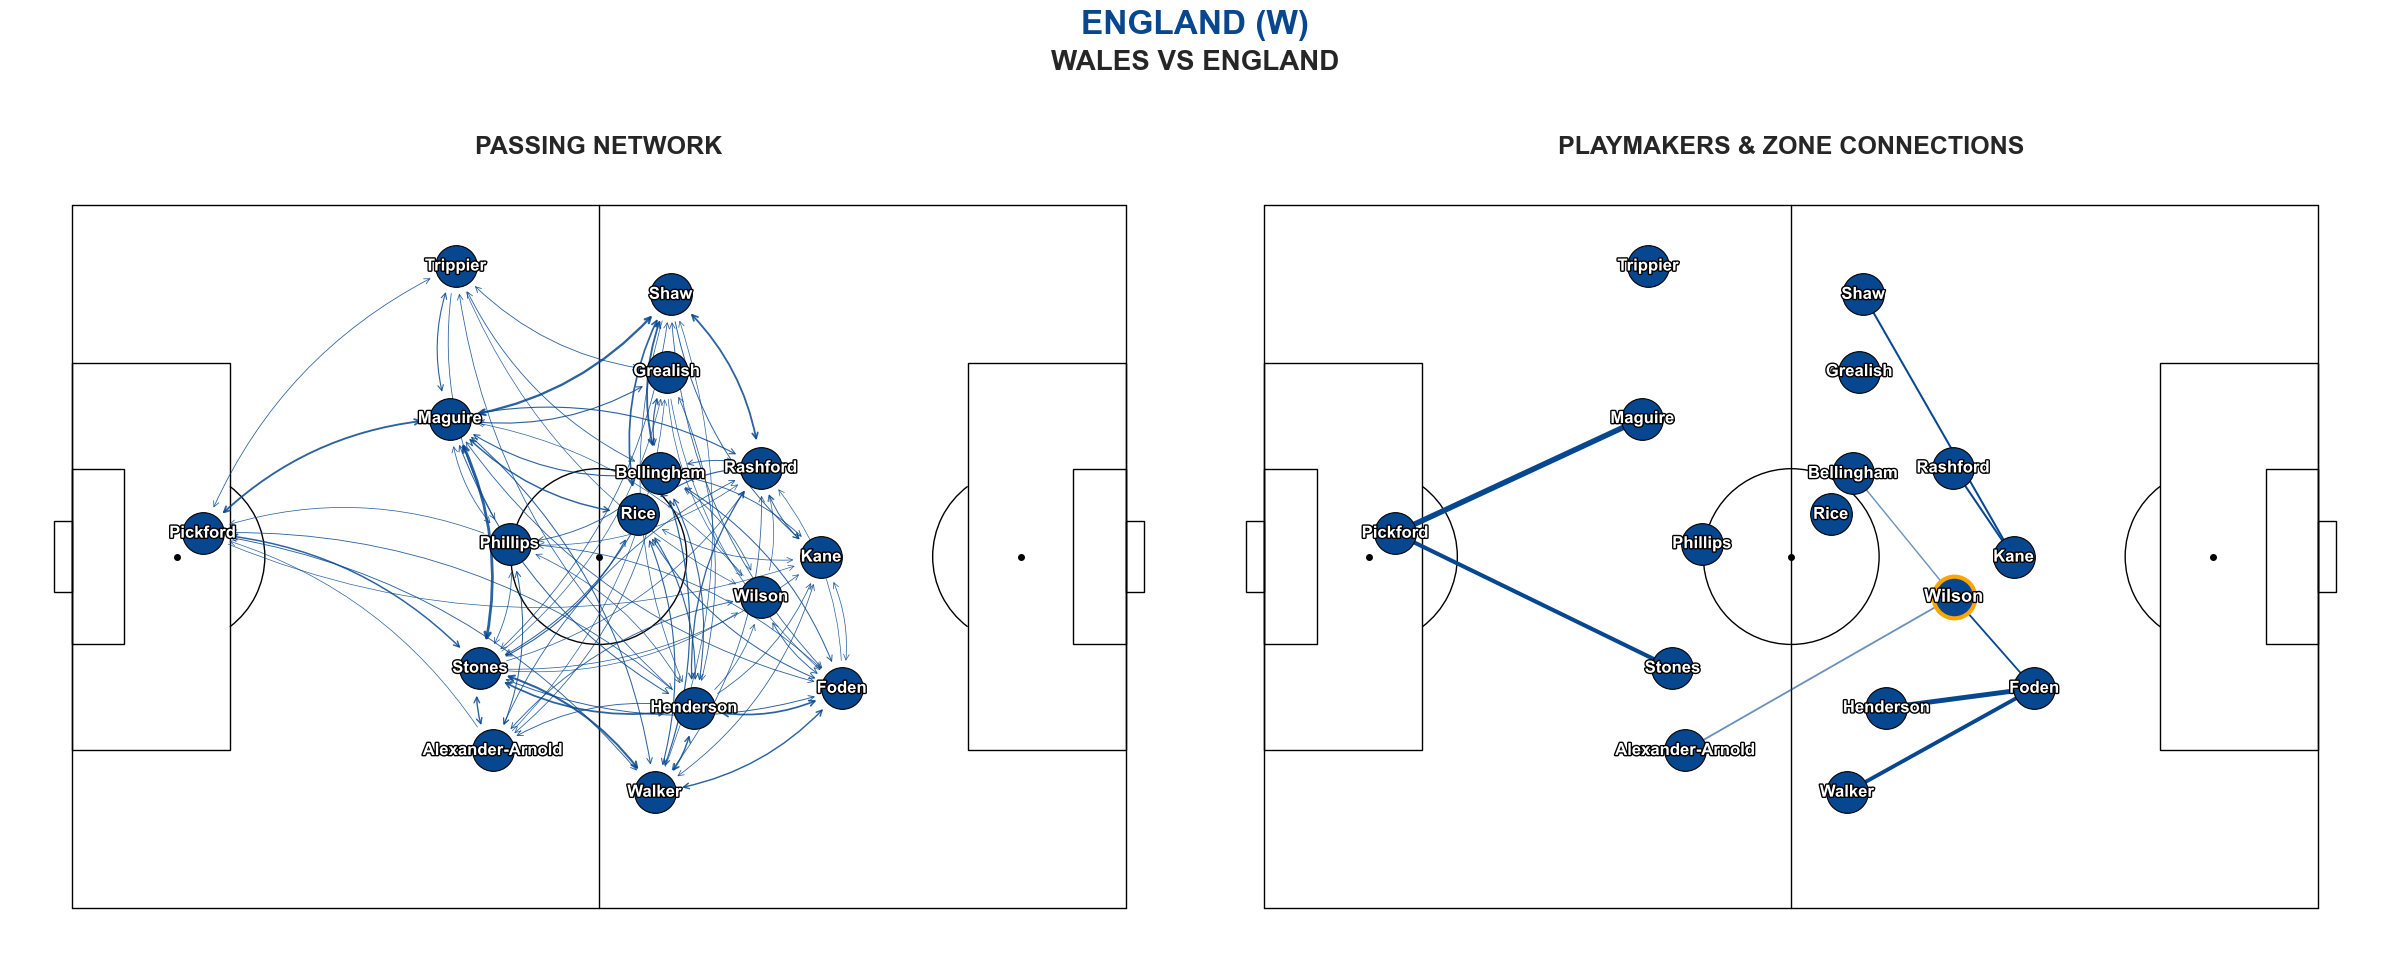

✓ Betweenness win visualization saved to: ..\viz\network_betweenness_win.png

Creating betweenness centrality - loss example...


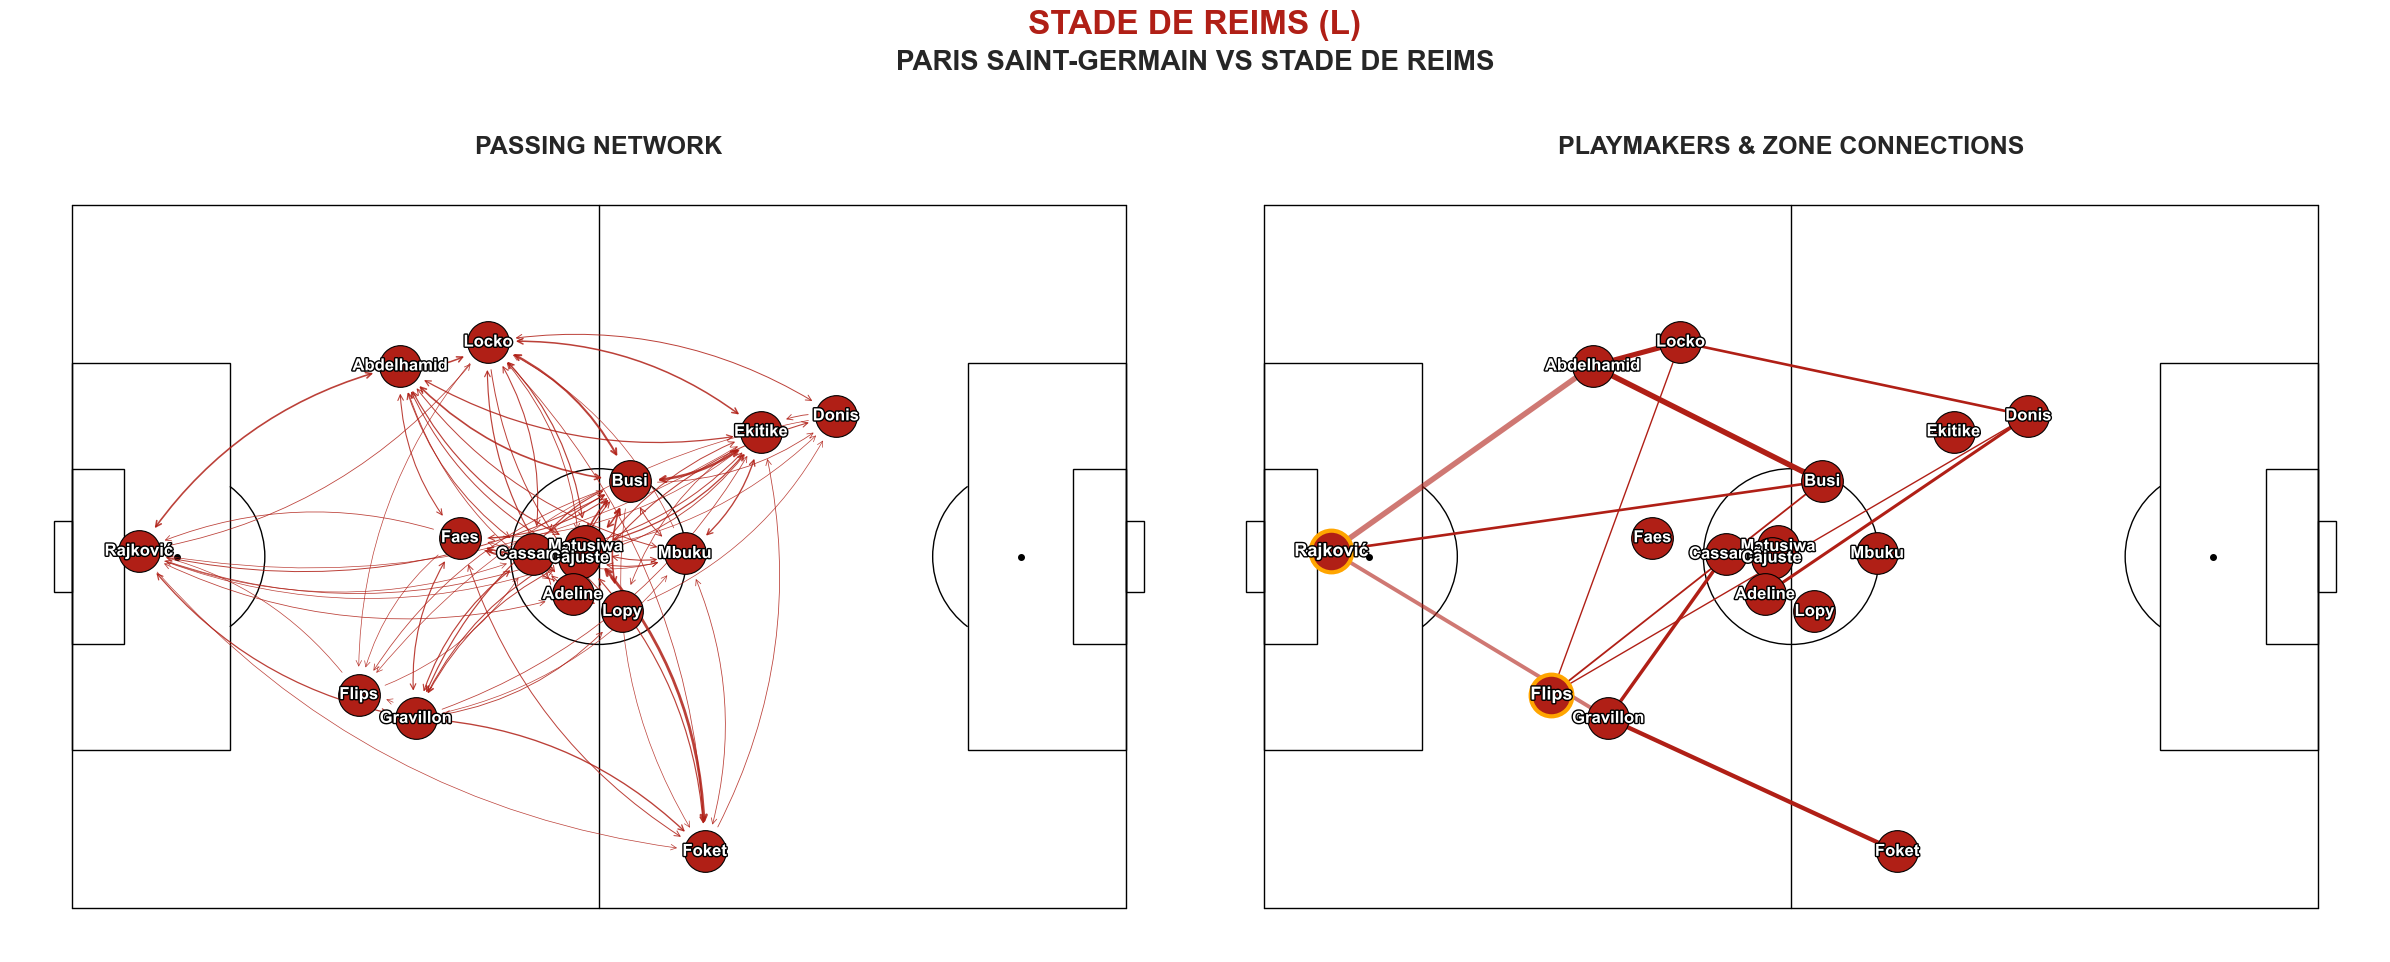

✓ Betweenness loss visualization saved to: ..\viz\network_betweenness_loss.png


In [11]:
# Generate betweenness analysis examples
print("\n=== GENERATING BETWEENNESS ANALYSIS EXAMPLES ===")

print("\nCreating betweenness centrality - win example...")
fig_win, axes_win = visualize_betweenness_analysis(
    network_summary, network_edges, player_positions,
    random_selection=True, final_result=1
)

plt.show()

save_path = VIZ_PATH / "network_betweenness_win.png"
fig_win.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Betweenness win visualization saved to: {save_path}")
plt.close(fig_win)

print("\nCreating betweenness centrality - loss example...")
fig_loss, axes_loss = visualize_betweenness_analysis(
    network_summary, network_edges, player_positions,
    random_selection=True, final_result=0
)

plt.show()

save_path = VIZ_PATH / "network_betweenness_loss.png"
fig_loss.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ Betweenness loss visualization saved to: {save_path}")
plt.close(fig_loss)